# pandapower Interface

This example (1) shows how to convert an ANDES system (`ssa`) to a pandapower network (`ssp`), (2) benchmarks the powerflow results, (3) shows how to alter `ssa` active power setpoints according to `ssp` results.

The following clarafications you might need to know:

1. This interface tracks static power flow model in ANDES: `Bus`, `Line`, `PQ`, `Shunt`, `PV`, and `Slack`. The dynamic model in ANDES is not tracked, including but not limited to `TurbineGov`, `SynGen`, and `Exciter`.
1. The interface converts the ``Slack`` in ANDES to ``gen`` in pandapower rather than ``ext_gen``.
1. **MUST NOT** verify power flow after initializing TDS in ANDES. ANDES does not allow running ``PFlow`` for systems with initialized TDS as it will break variable addressing.
1. If you want to track dynamic model outputs in ANDES and feedback into pandapower, you might need to manually transfer the results from ANDES to pandapower.

This interface is mainly developed by [Jinning Wang](https://jinningwang.github.io/).

In [1]:
import andes

from andes.interop.pandapower import to_pandapower, \
    make_link_table, runopp_map, add_gencost

andes.config_logger(20)

import pandapower as pp
import numpy as np
import pandas as pd

from math import pi

## Load case

Here we use the same ANDES system `ss0` to do the pandapower conversion, which leaves the `ssa` untouched.

This will be useful if you need to modify the `ssa` parametes or setpoints.

In [2]:
ssa = andes.load(andes.get_case('ieee14/ieee14_ieeet1.xlsx'),
                 setup=False,
                 no_output=True,
                 default_config=True)
ssa.Toggle.u.v = [0, 0]
ssa.setup()

ss0 = andes.load(andes.get_case('ieee14/ieee14_ieeet1.xlsx'),
                 setup=False,
                 no_output=True,
                 default_config=True)
ss0.Toggle.u.v = [0, 0]
ss0.setup()

Working directory: "/Users/jinningwang/Documents/work/andes/docs/source/examples"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1328 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/andes/cases/ieee14/ieee14_ieeet1.xlsx"...
Input file parsed in 0.0441 seconds.
System internal structure set up in 0.0236 seconds.
Working directory: "/Users/jinningwang/Documents/work/andes/docs/source/examples"
> Reloaded generated Python code of module "pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2553 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/andes/cases/ieee14/ieee14_ieeet1.xlsx"...
Input file parsed in 0.0367 seconds.
System internal structure set up in 0.0227 seconds.


True

## Convert to pandapower net

Convert ADNES system `ssa` to pandapower net `ssp`.

In [3]:
ssp = to_pandapower(ss0)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0029 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.957087684e-12
Converged in 4 iterations in 0.0038 seconds.
Power flow results are consistent. Conversion is successful.


Add generator cost data.

In [4]:
gen_cost = np.array([
        [2, 0, 0, 3, 0.0430293, 20, 0], 
        [2, 0, 0, 3, 0.25,      20, 0], 
        [2, 0, 0, 3, 0.01,      40, 0], 
        [2, 0, 0, 3, 0.01,      40, 0], 
        [2, 0, 0, 3, 0.01,      40, 0]
])

add_gencost(ssp, gen_cost)

True

Inspect the pandapower net `ssp`.

In [5]:
ssp

This pandapower network includes the following parameter tables:
   - bus (14 elements)
   - load (11 elements)
   - gen (5 elements)
   - shunt (2 elements)
   - line (16 elements)
   - trafo (4 elements)
   - poly_cost (5 elements)
 and the following results tables:
   - res_bus (14 elements)
   - res_line (16 elements)
   - res_trafo (4 elements)
   - res_load (11 elements)
   - res_shunt (2 elements)
   - res_gen (5 elements)

## Comapre Power Flow Results

Run power flow of `ssa`.

In [6]:
ssa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0039 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.957087684e-12
Converged in 4 iterations in 0.0045 seconds.


True

In [7]:
# ssa
ssa_res_gen = pd.DataFrame(columns=['name', 'p_mw', 'q_mvar', 'va_degree', 'vm_pu'])
ssa_res_gen['name'] = ssa.PV.as_df()['name']
ssa_res_gen['p_mw'] = ssa.PV.p.v * ssa.config.mva
ssa_res_gen['q_mvar'] = ssa.PV.q.v * ssa.config.mva
ssa_res_gen['va_degree'] = ssa.PV.a.v * 180 / pi
ssa_res_gen['vm_pu'] = ssa.PV.v.v
ssa_res_slack = pd.DataFrame([[ssa.Slack.name.v[0], ssa.Slack.p.v[0] * ssa.config.mva,
                              ssa.Slack.q.v[0] * ssa.config.mva, ssa.Slack.a.v[0] * 180 / pi,
                              ssa.Slack.v.v[0]]],
                             columns=ssa_res_gen.columns,
                             )
ssa_res_gen = pd.concat([ssa_res_gen, ssa_res_slack]).reset_index(drop=True)

# ssp
pp.runpp(ssp)
ssp_res_gen = pd.concat([ssp.gen['name'], ssp.res_gen], axis=1)

res_gen_concat = pd.concat([ssa_res_gen, ssp_res_gen], axis=1)

# ssa
ssa_pf_bus = ssa.Bus.as_df()[["name"]].copy()
ssa_pf_bus['v_andes'] = ssa.Bus.v.v
ssa_pf_bus['a_andes'] = ssa.Bus.a.v * 180 / pi

# ssp
ssp_pf_bus = ssa.Bus.as_df()[["name"]].copy()
ssp_pf_bus['v_pp'] = ssp.res_bus['vm_pu']
ssp_pf_bus['a_pp'] = ssp.res_bus['va_degree']

pf_bus_concat = pd.concat([ssa_pf_bus, ssp_pf_bus], axis=1)

### Generation

In the table below, the left half are ANDES results, and the right half are from pandapower

In [8]:
res_gen_concat.round(4)

,name,p_mw,q_mvar,va_degree,vm_pu,name,p_mw,q_mvar,va_degree,vm_pu
0,2,40.0000,30.4361,-1.7641,1.03,2,40.0000,30.4361,-1.7641,1.03
1,3,40.0000,12.5971,-3.5371,1.01,3,40.0000,12.5971,-3.5371,1.01
2,4,30.0000,20.9866,-6.4527,1.03,4,30.0000,20.9866,-6.4527,1.03
3,5,35.0000,7.3964,-1.5400,1.03,5,35.0000,7.3964,-1.5400,1.03
4,1,81.4272,-21.6171,0.0000,1.03,1,81.4272,-21.6171,0.0000,1.03


### Bus voltage and angle

Likewise, the left half are ANDES results, and the right half are from pandapower

In [9]:
pf_bus_concat.round(4)

,name,v_andes,a_andes,name,v_pp,a_pp
uid,,,,,,
0,BUS1,1.0300,0.0000,BUS1,1.0300,0.0000
1,BUS2,1.0300,-1.7641,BUS2,1.0300,-1.7641
2,BUS3,1.0100,-3.5371,BUS3,1.0100,-3.5371
3,BUS4,1.0114,-4.4098,BUS4,1.0114,-4.4098
4,BUS5,1.0173,-3.8430,BUS5,1.0173,-3.8430
5,BUS6,1.0300,-6.4527,BUS6,1.0300,-6.4527
6,BUS7,1.0225,-4.8852,BUS7,1.0225,-4.8852
7,BUS8,1.0300,-1.5400,BUS8,1.0300,-1.5400
8,BUS9,1.0218,-7.2459,BUS9,1.0218,-7.2459


## Generator dispatch based on OPF from pandapower

Prepare the link table.

In [10]:
# Asign the StaticGen with OPF, in this case, all the SynGen are GENROU
link_table = make_link_table(ssa)

In [11]:
link_table

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq
0,1,1.0,1,1,NaN,NaN,NaN,GENROU_1,ESST3A_2,TGOV1_1,BUS1,1.0,1.0
1,2,1.0,2,2,NaN,NaN,NaN,GENROU_2,EXST1_1,TGOV1_2,BUS2,1.0,1.0
2,3,1.0,3,3,NaN,NaN,NaN,GENROU_3,ESST3A_3,TGOV1_3,BUS3,1.0,1.0
3,4,1.0,4,6,NaN,NaN,NaN,GENROU_4,ESST3A_4,TGOV1_4,BUS6,1.0,1.0
4,5,1.0,5,8,NaN,NaN,NaN,GENROU_5,1,TGOV1_5,BUS8,1.0,1.0


Note: some Jupyter notebooks may not support inline plots. You can use the following command to enable it.

```python
import matplotlib
%matplotlib inline
```

In [12]:
import matplotlib
%matplotlib inline

Run the TDS in ADNES to 2s.


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-2 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Initialization for dynamics completed in 0.1282 seconds.
Initialization was successful.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0623 seconds.


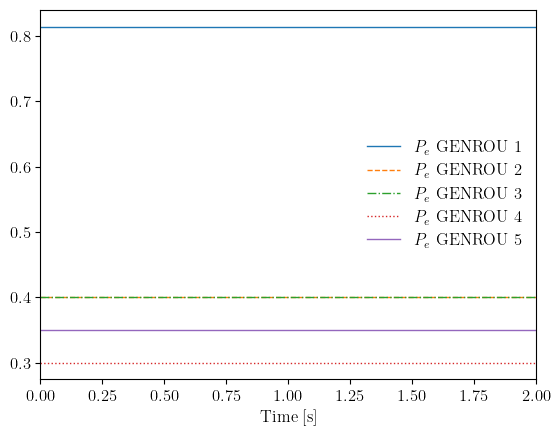

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [13]:
ssa.TDS.config.tf = 2
ssa.TDS.run()

ssa.TDS.plt.plot(ssa.GENROU.Pe)

Get the OPF results from pandapower. The `ssp_res` has been converted to p.u..

In [14]:
ssp_res = runopp_map(ssp, link_table)
ssp_res

ACOPF is solved.


,stg_idx,p,q,vm_pu,bus_idx,controllable,dg_idx,rg_idx,syg_idx,gov_idx,exc_idx
0,2,0.5,0.129107,1.096903,2,True,NaN,NaN,GENROU_2,TGOV1_2,EXST1_1
1,3,0.41275,0.149997,1.082551,3,True,NaN,NaN,GENROU_3,TGOV1_3,ESST3A_3
2,4,0.34426,0.099998,1.086084,6,True,NaN,NaN,GENROU_4,TGOV1_4,ESST3A_4
3,5,0.495878,0.085204,1.099996,8,True,NaN,NaN,GENROU_5,TGOV1_5,1
4,1,0.5,-0.079016,1.100000,1,True,NaN,NaN,GENROU_1,TGOV1_1,ESST3A_2


Now dispatch the resutls into `ssa`, where the active power setpoitns are updated to `TurbinGov.pref0`.

In [15]:
ssa_gov_idx = list(ssp_res['gov_idx'][~ssp_res['gov_idx'].isna()])
ssa.TurbineGov.set(src='pref0', idx=ssa_gov_idx, attr='v', value=ssp_res['p'][~ssp_res['gov_idx'].isna()])
ssa.TurbineGov.get(src='pref0', idx=ssa_gov_idx, attr='v')

array([0.49999998, 0.41274963, 0.34426   , 0.49587786, 0.50000031])

Now run the TDS to 50s.

In [16]:
ssa.TDS.config.tf = 50
ssa.TDS.run()

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=50.00 sec completed in 1.9001 seconds.


True

We can see the outputs of `GENROU` are rearranged by the OPF results.

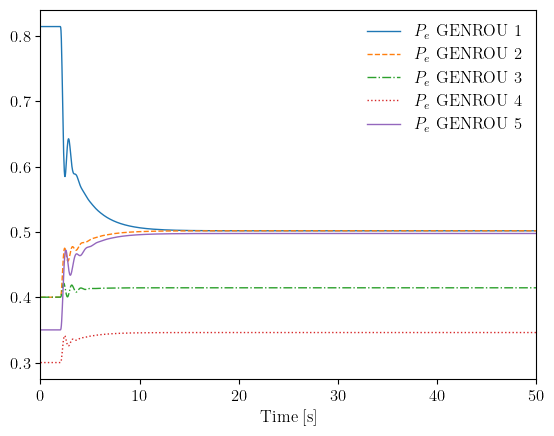

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [17]:
ssa.TDS.plt.plot(ssa.GENROU.Pe)